Дата начала 
 15/01
Дата окончания 
 28/01

In [19]:
import prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [20]:
filename = "data_metric_3.scv"

In [21]:
pd.read_csv(filename).head()

,ds,y
0,2022-02-01,0.084223
1,2022-02-02,0.114879
2,2022-02-03,0.133557
3,2022-02-04,0.135573
4,2022-02-05,0.132856


In [22]:
def prepare_data(csv_filename, y_val_name, ds_val_name):
    d = pd.read_csv(csv_filename)
    d = d[d[y_val_name] != 0]
    d[ds_val_name] = pd.to_datetime(d[ds_val_name], 
                                    #dayfirst = True
                                   )
    d = d.rename(columns={y_val_name: "y", ds_val_name: "ds"})
    d = d[["ds", "y"]]
    return d

def set_holidays():
    # Setting holidays 

    black_fridays = pd.DataFrame({
      'holiday': 'black_friday',
      'ds': pd.to_datetime(['2022-11-26', '2022-11-25', '2023-11-24',]),
      'lower_window': -14,
      'upper_window': 14,
    })
    new_years = pd.DataFrame({
      'holiday': 'new_year',
      'ds': pd.to_datetime(['2021-12-31', '2022-12-31', '2023-12-31']),
      'lower_window': -2,
      'upper_window': 7,
    })
    febs_23 = pd.DataFrame({
      'holiday': '23_feb',
      'ds': pd.to_datetime(['2021-02-23', '2022-02-23', '2023-02-23']),
      'lower_window': -4,
      'upper_window': 3,
    })
    
    mays_1 = pd.DataFrame({
      'holiday': '1_may',
      'ds': pd.to_datetime(['2021-05-01', '2022-05-01', '2023-05-01']),
      'lower_window': -2,
      'upper_window': 2,
    })
    
    
    holidays = pd.concat((black_fridays, new_years, febs_23, mays_1))
    return holidays

In [24]:
d = prepare_data(filename, "y", "ds")
d.head()

holidays = set_holidays()

In [25]:
test = d[d["ds"] >= "2024-01-15"]
train = test = d[d["ds"] < "2024-01-15"]

In [26]:
# Setting Baseline Prophet model
model = Prophet(
            yearly_seasonality=7, 
            weekly_seasonality=10, 
            holidays=holidays, 
            growth = "linear", 
            holidays_prior_scale = 10,
            n_changepoints = 20,)
model.fit(train)

21:34:05 - cmdstanpy - INFO - Chain [1] start processing
21:34:05 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Creating Future Dataset for Forecasting 
future = model.make_future_dataframe(periods=50)
future.tail()

,ds
755,2024-02-29
756,2024-03-01
757,2024-03-02
758,2024-03-03
759,2024-03-04


In [28]:
forecast = model.predict(future)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


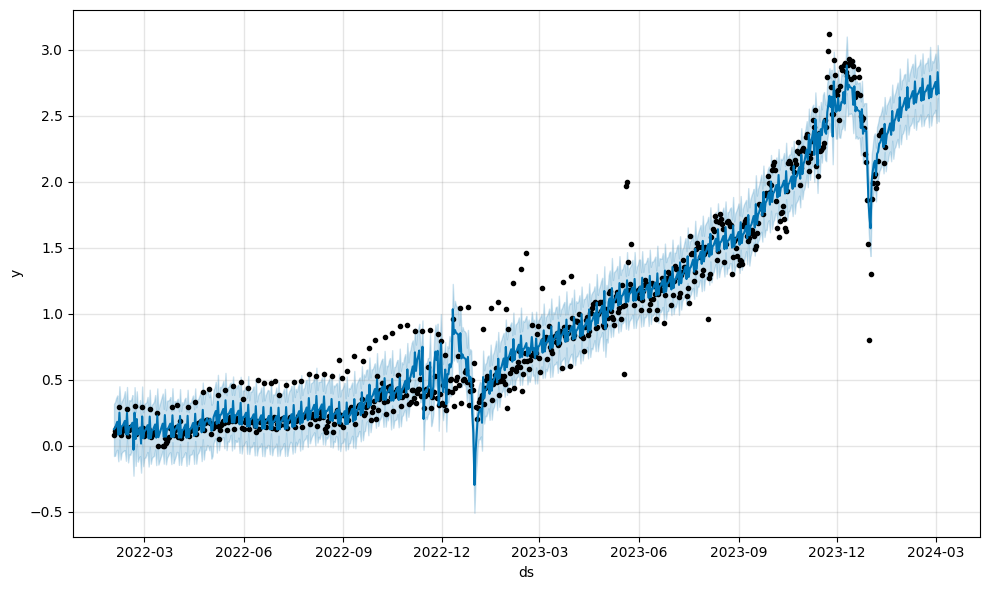

In [29]:
predict_plot = model.plot(forecast)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

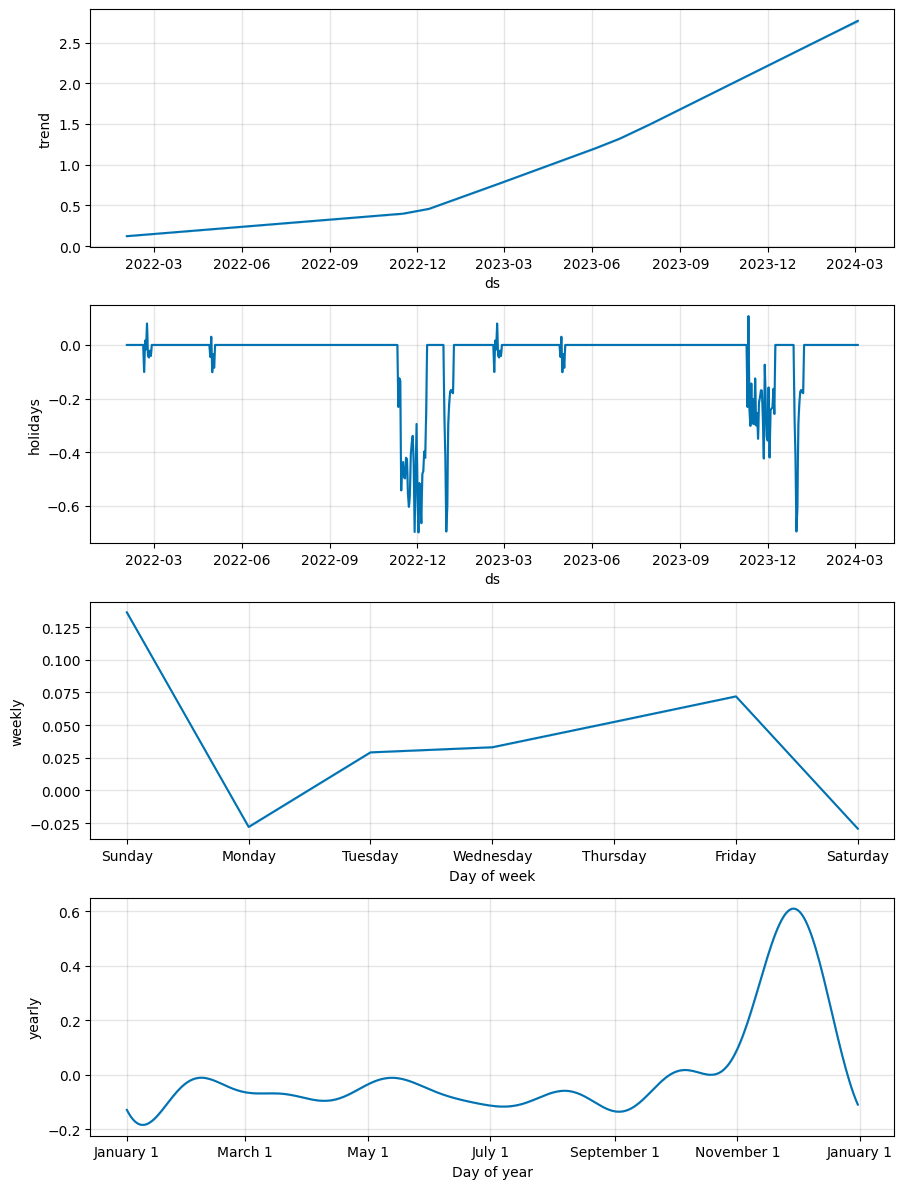

In [30]:
components_plot = model.plot_components(forecast)

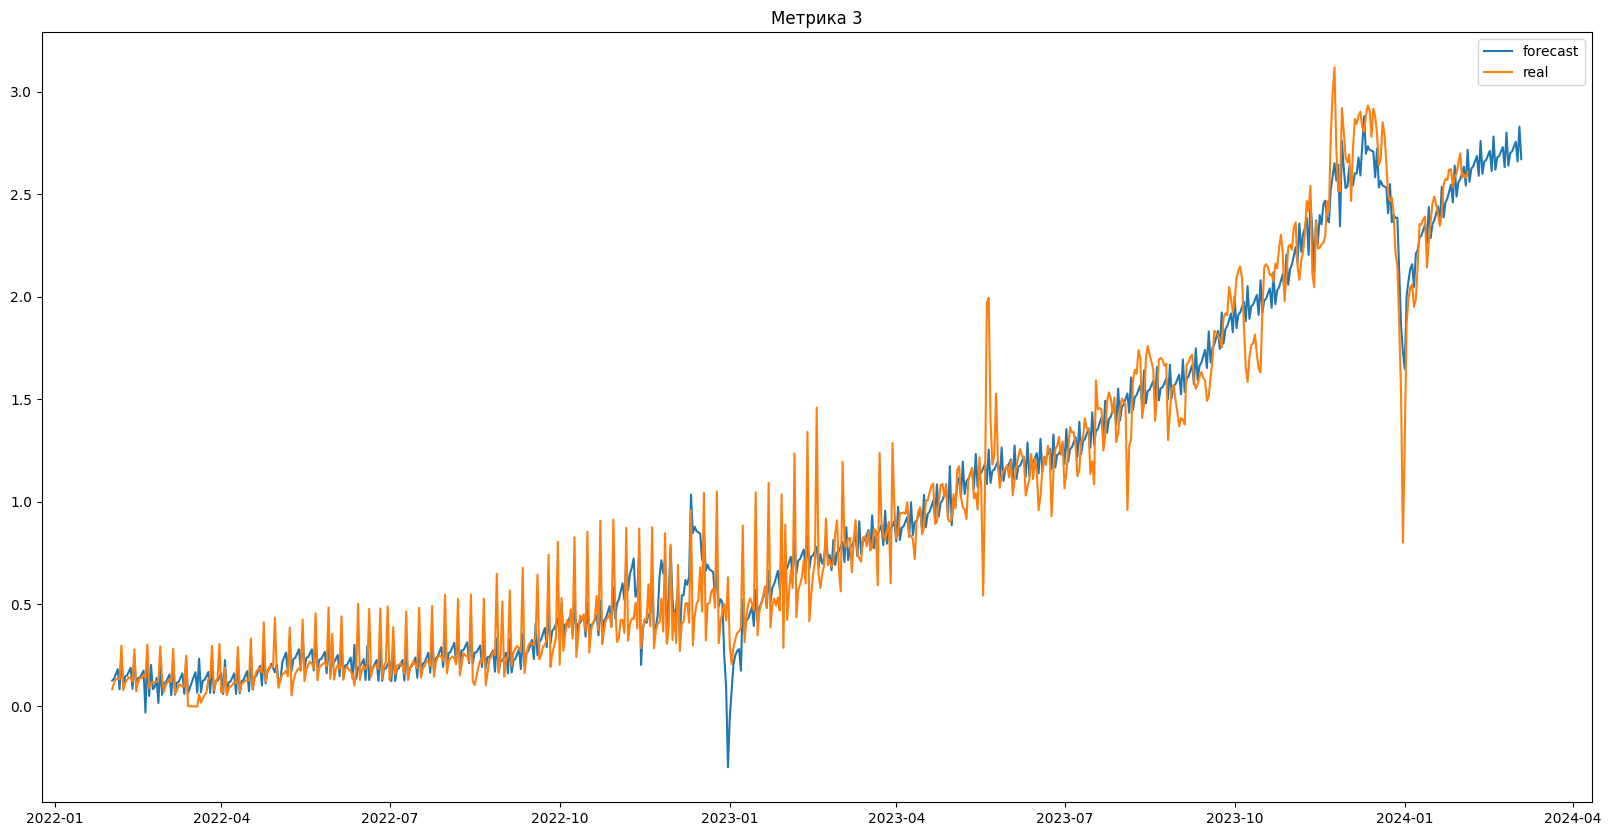

In [31]:
df = pd.merge(d, forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], how = "right", on = "ds")

plt.figure()
plt.plot(df.ds, df.yhat, label = "forecast", ls = "-")
plt.plot(df.ds, df.y, label = "real")
plt.title("Метрика 3")
plt.legend()
plt.show()

In [32]:
plot_only_test = df[df["ds"] <= "2024-01-28"].tail(50)

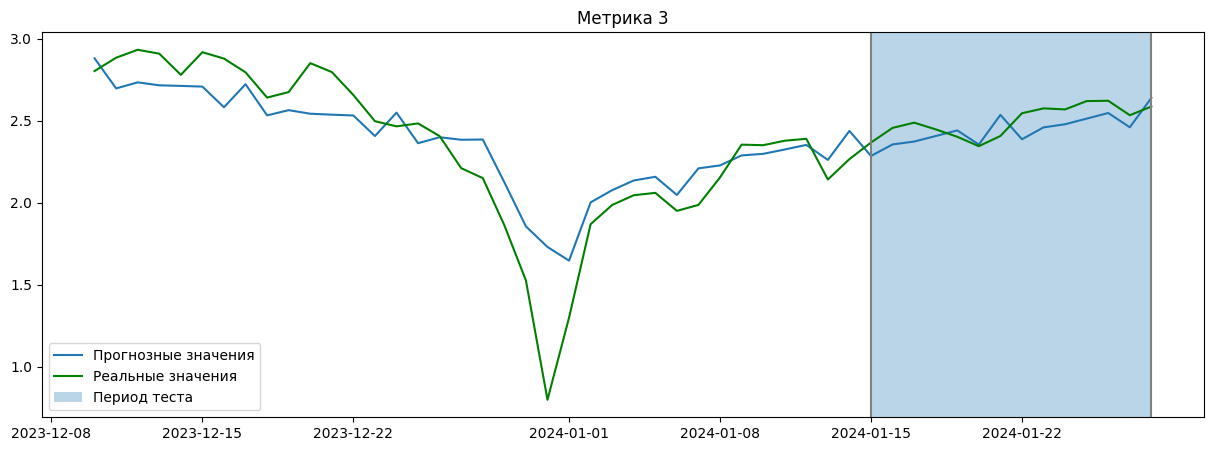

In [34]:
plt.rcParams["figure.figsize"] = (15,5)
import datetime as dt


plt.figure()
plt.plot(plot_only_test["ds"], plot_only_test["yhat"], label = "Прогнозные значения", ls = "-")
plt.plot(plot_only_test.ds, plot_only_test["y"], label = "Реальные значения", color = "green")
plt.axvline(dt.datetime(2024, 1, 15),  color = "grey")
plt.axvline(dt.datetime(2024, 1, 28),  color = "grey")
plt.axvspan(dt.datetime(2024, 1, 15), dt.datetime(2024, 1, 28), alpha = 0.3, label = "Период теста")
plt.title("Метрика 3")
plt.legend()
plt.savefig("total_adv_rev.png")
plt.show()

In [35]:
prcnt_cnhg = (plot_only_test.mean()["yhat"] - plot_only_test.mean()["y"])/plot_only_test.mean()["y"]
prcnt_cnhg*100

0.2046507155834253

In [36]:
plot_only_test.mean()

ds            2024-01-03 12:00:00
y                        2.382227
yhat                     2.387102
yhat_lower               2.179702
yhat_upper               2.595199
dtype: object

In [37]:
plot_only_test.std()

ds            14 days 13:51:25.609286585
y                               0.420995
yhat                            0.253022
yhat_lower                       0.25182
yhat_upper                      0.251299
dtype: object

In [38]:
plot_only_test.count()

ds            50
y             50
yhat          50
yhat_lower    50
yhat_upper    50
dtype: int64

t test result 
total:
The two-tailed P value is less than 0.0001
By conventional criteria, this difference is considered to be extremely statistically significant

In [39]:
test_test = plot_only_test[(plot_only_test["ds"] >= "2024-01-15") & (plot_only_test["ds"] <= "2024-01-28")]
test_test.mean()

ds            2024-01-21 12:00:00
y                        2.497253
yhat                     2.445254
yhat_lower               2.235541
yhat_upper               2.653827
dtype: object

In [40]:
test_test.std()

ds            4 days 04:23:57.131462720
y                              0.093982
yhat                           0.093703
yhat_lower                     0.090542
yhat_upper                     0.089222
dtype: object

In [41]:
test_test.count()

ds            14
y             14
yhat          14
yhat_lower    14
yhat_upper    14
dtype: int64

test period:
The two-tailed P value equals 0.2735
By conventional criteria, this difference is considered to be not statistically significant.

In [42]:
249725344.591818/10e6

24.9725344591818

In [43]:
train_tt = df[(df["ds"] >= "2023-12-01") & ( df["ds"] < "2024-01-15")]


model_error  = (train_tt.mean()["yhat"] - train_tt.mean()["y"])/train_tt.mean()["y"]
model_error * 100

-0.39538024461224996